# Overview
The **objective** of this notebook is to visualize the data assimilation results generated from [the DART_PFLOTRAN_Integrate notebook](./DART_PFLOTRAN_Integrate.ipynb):
1. [x] [Configuration](#parameter): define directories, file locations, and other parameters
- [x] [Visualize spatial average](#plot_spatial_average): plot the time evolution of spatial-averaged prior and posterior results
- [x] [Visualize time evolution along one axis](#plot_along_zaxis):

<a id='parameter'></a>
# Configuration

In [1]:
import os
import sys
import pickle
import f90nml
import numpy as np
from math import floor
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
%load_ext autoreload
%autoreload 2

****************
**Define the locations of application folder, DART-PFLOTRAN interface folder, and the configuation file of interest**

In [2]:
# Main directory names
temp_app_dir = "/Users/jian449/Codes/DART/manhattan/models/pflotran/applications/template"          # The template for application folder
app_dir      = "/Users/jian449/Codes/DART/manhattan/models/pflotran/applications/1dthermal"          # The application folder name
dart_dir     = "/Users/jian449/Codes/DART/manhattan"
dart_pf_dir  = "/Users/jian449/Codes/DART/manhattan/models/pflotran"     # The dart pflotran utitlity folder name
# temp_app_dir = os.path.abspath("../template" )          # The template for application folder
# app_dir      = os.path.abspath("../1dthermal/")          # The application folder name
# dart_dir     = os.path.abspath("../../../../")
# dart_pf_dir  = os.path.join(dart_dir, "models/pflotran")     # The dart pflotran utitlity folder name
# Get the configuration file
config_file  = os.path.join(app_dir, "work/config.nml")

****************
**Import the visualization functions**

In [3]:
sys.path.append(dart_pf_dir)
from utils.plot_da_result import DaResults, plot_compare_multiple_daresults
dar = DaResults(config_file)
dar.setup(from_concatenated=2)
nvar = dar.nvar

<a id='plot_spatial_average'></a>
# Visualize spatial average results

/usr/local/anaconda3/envs/geosci/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  func(*args, **kwargs)
/usr/local/anaconda3/envs/geosci/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


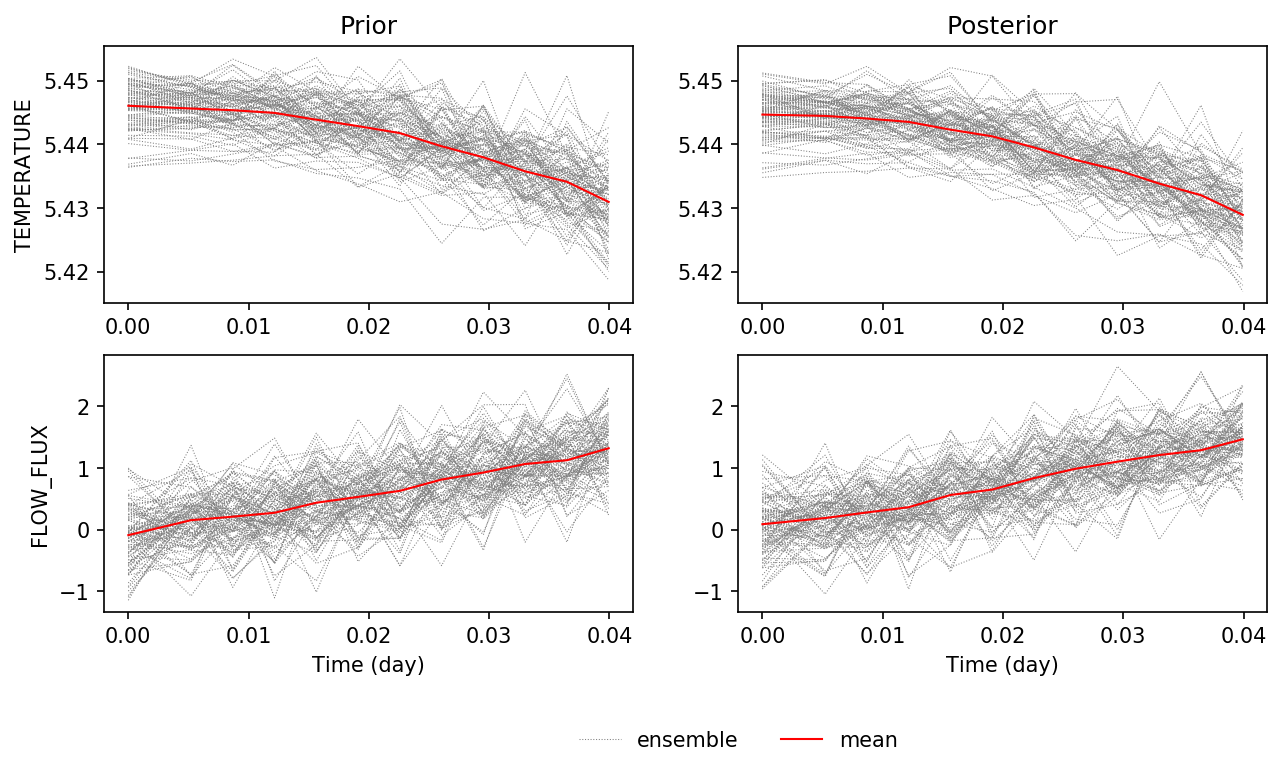

In [4]:
fig = plt.figure(num=1,dpi=150, figsize=(10,5), constrained_layout=True)
gs = gridspec.GridSpec(nvar, 2, width_ratios=[1, 1])
axes = np.empty([nvar, 2], dtype=object)
for i in range(nvar):
    axes[i, 0] = plt.subplot(gs[i, 0])
    axes[i, 1] = plt.subplot(gs[i, 1], sharey=axes[i, 0], sharex=axes[i, 0])
dar.plot_spatial_average(axes)

<a id='plot_along_zaxis'></a>
# Visualize temporal evolution along one dimension

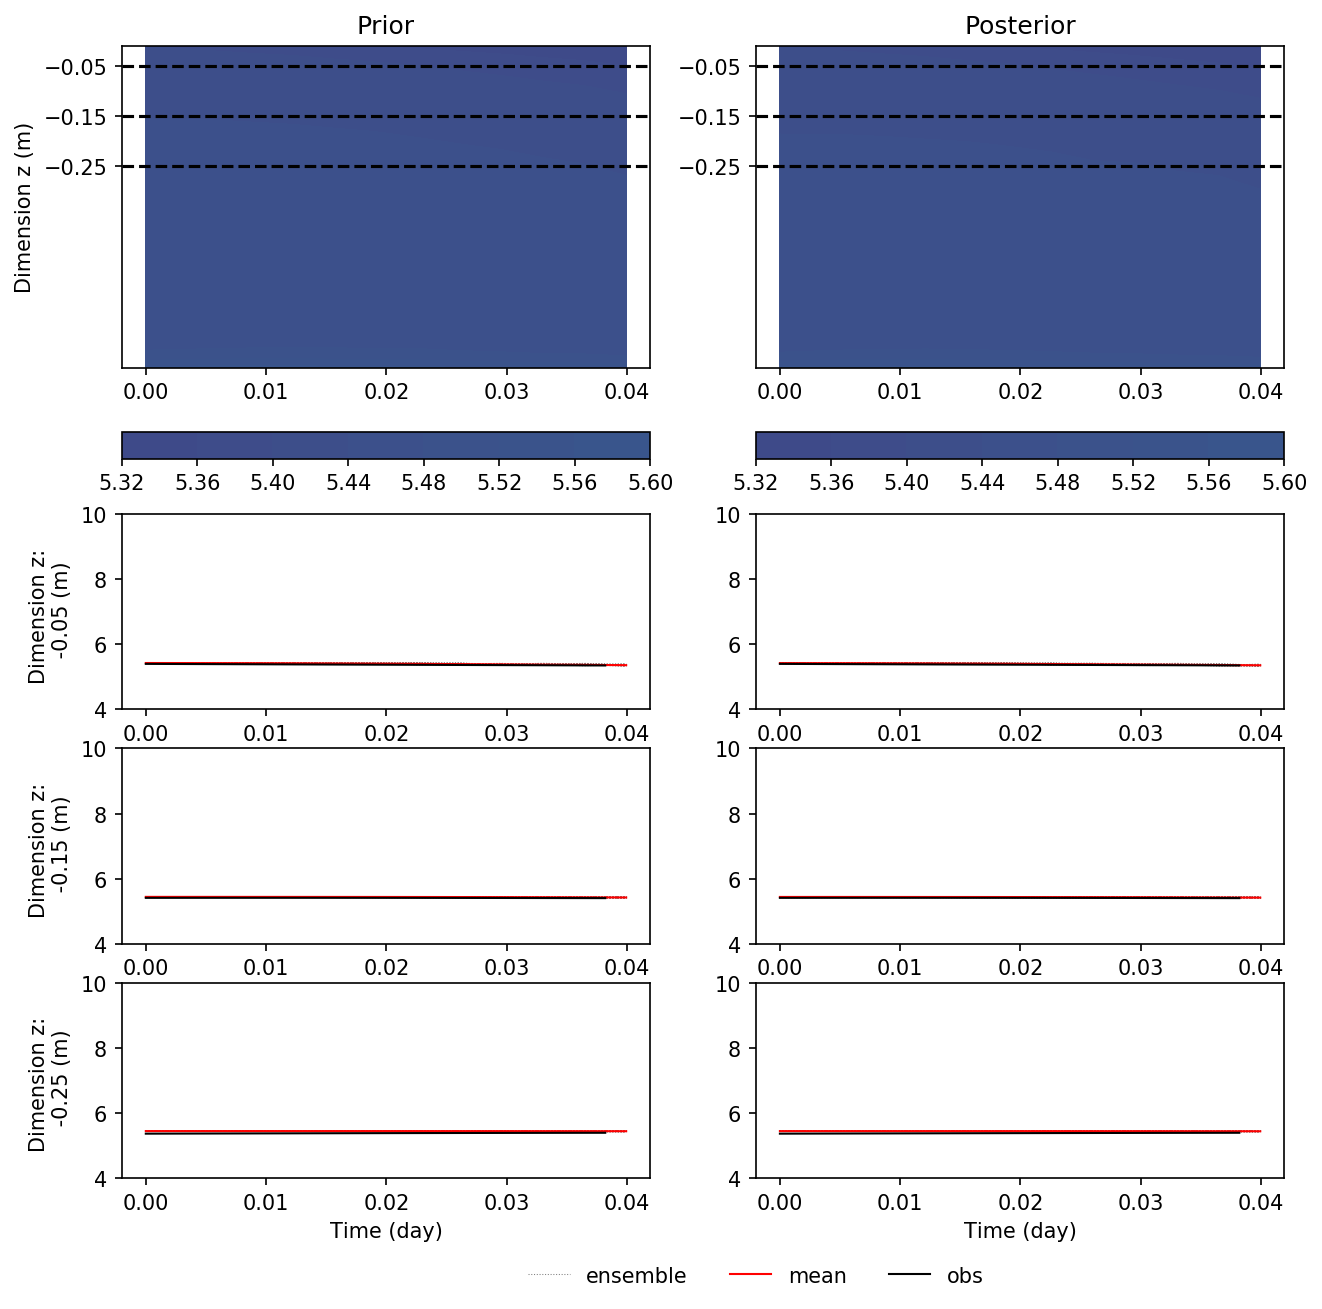

In [5]:
dar.plot_oned_obs('TEMPERATURE', figsize=(10,10), dim_str='z', vmin=4, vmax=10, ylim=[4, 10])

# Compare the true with analyzed results (one variable, spatially averaged)

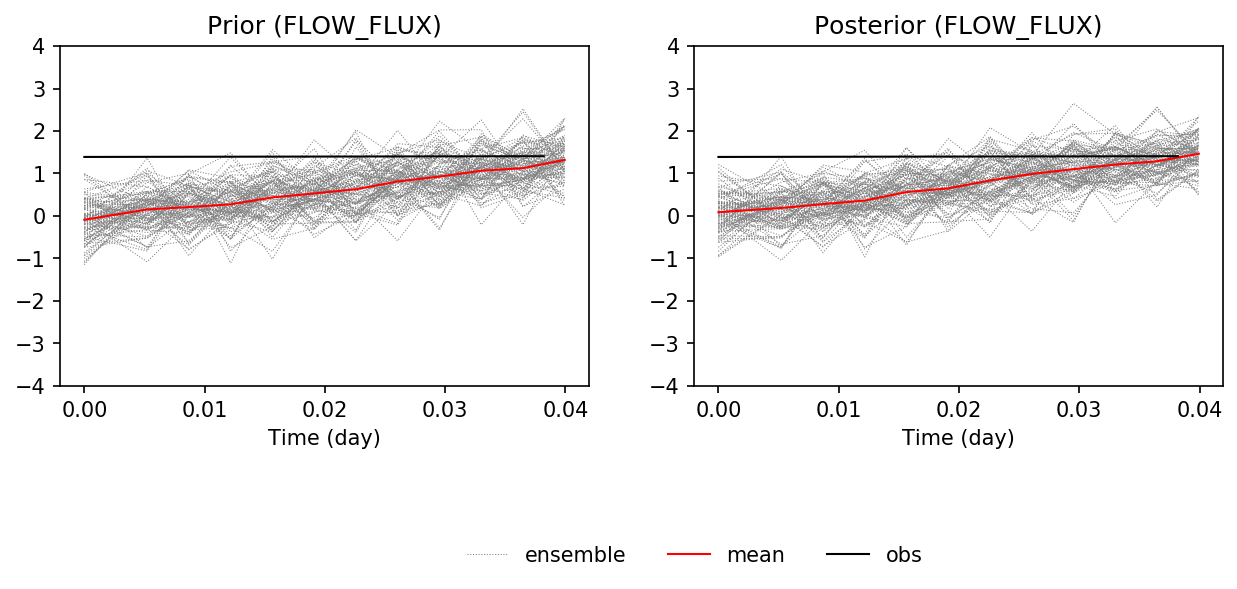

In [6]:
flux_file = os.path.join(app_dir, "pflotran_input/flux_1d.csv")
fig = plt.figure(num=1,dpi=150, figsize=(10,3), constrained_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axes = np.empty(2, dtype=object)
axes[0] = plt.subplot(gs[0, 0])
axes[1] = plt.subplot(gs[0, 1], sharey=axes[0], sharex=axes[0])
dar.compare_univar_spatial_average(var_name='FLOW_FLUX', true_file_name=flux_file, axes=axes, ylim=[-4, 4])

# This part is specific for 1d-thermal example
We would like to compare EnKF results with EnKS based on Kewei's work

In [7]:
# Get the Kewei's results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime

assim_start_me, assim_start_enks = dar.assim_start_time, "2017-04-01 02:00:00"
# flux_posterior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_posterior_woflowdir_mda1.txt")
# flux_prior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_prior_woflowdir_mda1.txt")
flux_posterior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_posterior_woflowdir.txt")
flux_prior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_prior_woflowdir.txt")
true_set = pd.read_csv(flux_file)
prior, posterior = np.loadtxt(flux_prior_file), np.loadtxt(flux_posterior_file)
_, nens = prior.shape

In [8]:
# Get the time index
model_start_time, model_end_time = dar.model_start_time, dar.model_end_time
ref_time           = datetime.strptime(assim_start_me, "%Y-%m-%d %H:%M:%S")
true_set_raw_time  = true_set.iloc[:, 0].values
true_set_dates     = np.array([datetime.strptime(t, '%m/%d/%Y %H:%M') for t in true_set_raw_time])
dates_ref          = [t-ref_time for t in true_set_dates]
true_set_time      = np.array([t.days+float(t.seconds)/86400. for t in dates_ref])
true               = true_set.iloc[:, 1].values
true_set_used_ind  = (true_set_time >= model_start_time) & (true_set_time <= model_end_time)
true_set_time_used = true_set_time[true_set_used_ind]
true_set_used      = true[true_set_used_ind]

# ref_time_enks      = datetime.strptime(assim_start_enks, "%Y-%m-%d %H:%M:%S")
# enks_set_time = true_set_time[true_set_dates > ref_time_enks]
# enks_ind  = (enks_set_time >= model_start_time) & (enks_set_time <= model_end_time)
model_time_list = dar.model_time_list
ntime = len(model_time_list)
analyzed_prior_ens = prior[1:1+ntime,:].T
analyzed_posterior_ens = posterior[1:1+ntime, :].T

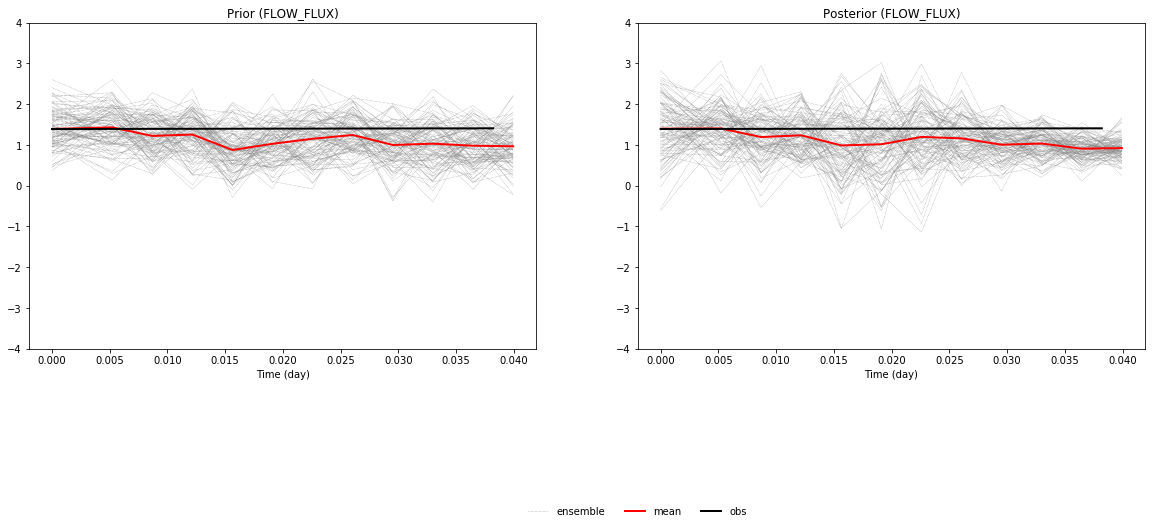

In [9]:
# Plot
ylim=[-4, 4]
fig = plt.figure(num=1, figsize=(20, 6), constrained_layout=True)
gs  = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
# Plot the prior
ax1 = plt.subplot(gs[0, 0])
for j in range(nens):
    prior_ens = analyzed_prior_ens[j, :]
    line1, = ax1.plot(model_time_list, prior_ens, color='grey',
                      linewidth=0.5, linestyle=':', label='ensemble')
prior_mean = np.mean(analyzed_prior_ens, axis=(0))
line2, = ax1.plot(model_time_list, prior_mean, color='red',
                  linewidth=2, label='mean')
line3, = ax1.plot(true_set_time_used, true_set_used, color='black',
                  linewidth=2, label='obs')

# Plot the posterior
ax2 = plt.subplot(gs[0, 1])
for j in range(nens):
    posterior_ens = analyzed_posterior_ens[j, :]
    line1, = ax2.plot(model_time_list, posterior_ens, color='grey',
                      linewidth=0.5, linestyle=':', label='ensemble')
posterior_mean = np.mean(analyzed_posterior_ens, axis=(0))
line2, = ax2.plot(model_time_list, posterior_mean, color='red',
                  linewidth=2, label='mean')
line3, = ax2.plot(true_set_time_used, true_set_used, color='black',
                  linewidth=2, label='obs')

# Plot the legends
plt.legend((line1, line2, line3), ('ensemble', 'mean', 'obs'),
           frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.0, -0.5))

# Plot the labels and titles
ax1.set_title("Prior ({})".format('FLOW_FLUX'))
ax2.set_title("Posterior ({})".format('FLOW_FLUX'))
ax1.set_xlabel("Time (day)")
ax2.set_xlabel("Time (day)")
ax1.set_ylim(ylim)
ax2.set_ylim(ylim);

In [10]:
# Get the Kewei's results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime

assim_start_me, assim_start_enks = dar.assim_start_time, "2017-04-01 02:00:00"
flux_posterior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_posterior_woflowdir_mda1.txt")
flux_prior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_prior_woflowdir_mda1.txt")
# flux_posterior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_posterior_woflowdir.txt")
# flux_prior_file = os.path.join(app_dir, "pflotran_input/flux_Kewei_prior_woflowdir.txt")
true_set = pd.read_csv(flux_file)
prior, posterior = np.loadtxt(flux_prior_file), np.loadtxt(flux_posterior_file)
_, nens = prior.shape

In [11]:
# Get the time index
model_start_time, model_end_time = dar.model_start_time, dar.model_end_time
ref_time           = datetime.strptime(assim_start_me, "%Y-%m-%d %H:%M:%S")
true_set_raw_time  = true_set.iloc[:, 0].values
true_set_dates     = np.array([datetime.strptime(t, '%m/%d/%Y %H:%M') for t in true_set_raw_time])
dates_ref          = [t-ref_time for t in true_set_dates]
true_set_time      = np.array([t.days+float(t.seconds)/86400. for t in dates_ref])
true               = true_set.iloc[:, 1].values
true_set_used_ind  = (true_set_time >= model_start_time) & (true_set_time <= model_end_time)
true_set_time_used = true_set_time[true_set_used_ind]
true_set_used      = true[true_set_used_ind]

# ref_time_enks      = datetime.strptime(assim_start_enks, "%Y-%m-%d %H:%M:%S")
# enks_set_time = true_set_time[true_set_dates > ref_time_enks]
# enks_ind  = (enks_set_time >= model_start_time) & (enks_set_time <= model_end_time)
model_time_list = dar.model_time_list
ntime = len(model_time_list)
analyzed_prior_ens = prior[1:1+ntime,:].T
analyzed_posterior_ens = posterior[1:1+ntime, :].T

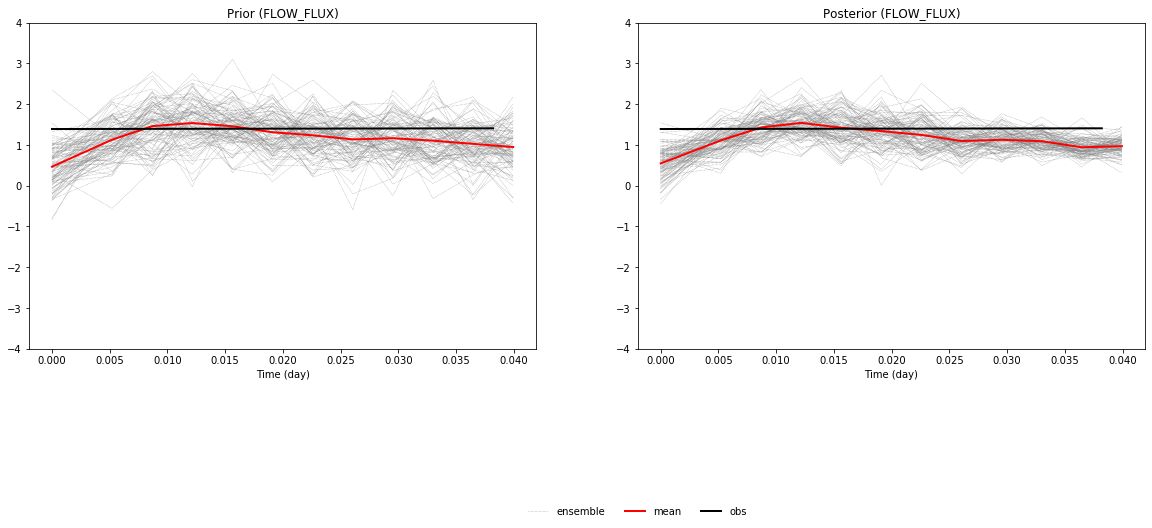

In [12]:
# Plot
ylim=[-4, 4]
fig = plt.figure(num=1, figsize=(20, 6), constrained_layout=True)
gs  = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
# Plot the prior
ax1 = plt.subplot(gs[0, 0])
for j in range(nens):
    prior_ens = analyzed_prior_ens[j, :]
    line1, = ax1.plot(model_time_list, prior_ens, color='grey',
                      linewidth=0.5, linestyle=':', label='ensemble')
prior_mean = np.mean(analyzed_prior_ens, axis=(0))
line2, = ax1.plot(model_time_list, prior_mean, color='red',
                  linewidth=2, label='mean')
line3, = ax1.plot(true_set_time_used, true_set_used, color='black',
                  linewidth=2, label='obs')

# Plot the posterior
ax2 = plt.subplot(gs[0, 1])
for j in range(nens):
    posterior_ens = analyzed_posterior_ens[j, :]
    line1, = ax2.plot(model_time_list, posterior_ens, color='grey',
                      linewidth=0.5, linestyle=':', label='ensemble')
posterior_mean = np.mean(analyzed_posterior_ens, axis=(0))
line2, = ax2.plot(model_time_list, posterior_mean, color='red',
                  linewidth=2, label='mean')
line3, = ax2.plot(true_set_time_used, true_set_used, color='black',
                  linewidth=2, label='obs')

# Plot the legends
plt.legend((line1, line2, line3), ('ensemble', 'mean', 'obs'),
           frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.0, -0.5))

# Plot the labels and titles
ax1.set_title("Prior ({})".format('FLOW_FLUX'))
ax2.set_title("Posterior ({})".format('FLOW_FLUX'))
ax1.set_xlabel("Time (day)")
ax2.set_xlabel("Time (day)")
ax1.set_ylim(ylim)
ax2.set_ylim(ylim);

In [13]:
np.mean(dar.prior[1,:,-20,0,0,0]), np.std(dar.prior[1,:,-1,0,0,0])

IndexError: index -20 is out of bounds for axis 2 with size 12

In [ ]:
np.mean(dar.posterior[1,:,-20,0,0,0]), np.std(dar.posterior[1,:,-1,0,0,0])